In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [38]:
from funcs.cleaning import fit_spline
from astropy.io import fits
from astropy.table import Table

In [22]:
koi = pd.read_csv('../KOI.csv', index_col='kepid').sort_index()

In [23]:
koi.index.values

array([  757450,   892772,  1025986, ..., 12885212, 12885212, 12935144])

In [24]:
'{:09d}'.format(757450)

'000757450'

In [25]:
data = Table.read('../fits/kplr{:09d}-2009166043257_llc.fits'.format(koi.index.values[0]))['TIME','PDCSAP_FLUX']

In [26]:
t = np.array(data['TIME'])
f = np.array(data['PDCSAP_FLUX'])

In [75]:
class main():
    def __init__(self, system_id, koi):
        data = Table.read('../fits/kplr{:09d}-2009166043257_llc.fits'.format(system_id))['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']
        self.time = np.array(data['TIME'])
        self.flux = np.array(data['PDCSAP_FLUX'])
        self.fluxerr = np.array(data['PDCSAP_FLUX_ERR'])
        self.period = koi.loc[system_id]['koi_period']
    
    def plot(self):
        fig, ax = plt.subplots(1,1, figsize=(10,3))
        ax.plot(self.time, self.flux)
        
    def clean_arrays(self):
        
        print('no. datapoints prior to cleaning: {}'.format(len(self.time)))
        # make sure data x vals are in increasing numbers
        order = np.argsort(self.time)
        self.flux = self.flux[order]
        self.time = self.time[order]
        if isinstance(self.fluxerr,np.ndarray):
            self.fluxerr = self.fluxerr[order]

        # ensure no nans before fitting
        mask = ~np.isnan(self.flux) & ~np.isnan(self.time)
        self.flux = self.flux[mask]
        self.time = self.time[mask]
        print('no. datapoints after cleaning: {}'.format(len(self.time)))
        if isinstance(self.fluxerr,np.ndarray):
            self.fluxerr = self.fluxerr[mask]
            
    def fold_data_new(self, plot=True):
        self.time -= self.time[0]
        self.time = np.mod(self.time,self.period)
        if plot:
            plt.scatter(self.time,self.flux,s=0.5)
            plt.title('folded data on period %s days' %self.period)
            plt.show()
        
    def remove_stellar_activity(self,nknots=50):

        tck = fit_spline(self.time,self.flux,nknots=nknots)
        mask = np.ones(len(self.time),dtype=bool)
        converged = False
        n = 0
        while not converged:
            self.time = self.time[mask]
            self.flux = self.flux[mask]
            self.fluxerr = self.fluxerr[mask]
            tck = fit_spline(self.time,self.flux,nknots=nknots)
            y = tck(self.time)
            mask = (self.flux+3*self.fluxerr > y) & (self.flux-3*self.fluxerr < y)
            if mask.sum()==len(mask):
                converged=True
                print('spline-fit converged after %i iterations.' %n)
            else:
                n+=1

        # fit converged spline back on original data...

#         time = obs[1].data.TIME
#         flux = obs[1].data.PDCSAP_FLUX
#         fluxerr = obs[1].data.PDCSAP_FLUX_ERR

#         time,flux,fluxerr = clean_arrays(time,flux,fluxerr)

        plt.scatter(self.time,self.flux,s=0.5)
        plt.plot(self.time,tck(self.time))
        plt.title('data with spline overplotted')
        plt.show()

        self.flux -= tck(self.time)
        plt.scatter(self.time,self.flux,s=0.5)
        plt.title('data with spline removed')
        plt.show()

#         return time,flux,fluxerr,tck

In [76]:
a = main(757450, koi)

In [77]:
a.clean_arrays()

no. datapoints prior to cleaning: 1639
no. datapoints after cleaning: 1624


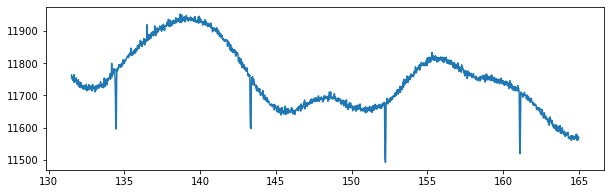

In [78]:
a.plot()

no. datapoints prior to cleaning: 1624
no. datapoints after cleaning: 1624
spline-fit converged after 2 iterations.


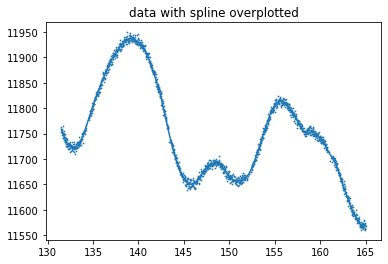

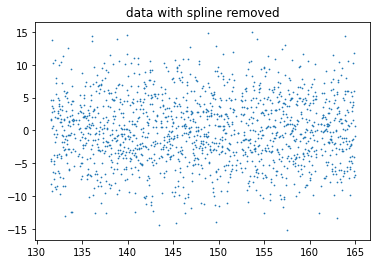

In [79]:
a.remove_stellar_activity()

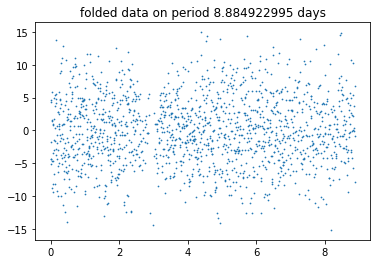

In [80]:
a.fold_data_new()